###  앙상블 학습

* 앙상블 학습의 유형은 보팅, 배깅, 부스팅 세가지로 나눌 수 있으며 이외에도 스태깅을 포함한 다양한 앙상블 방법이 있다.
* 보팅의 경우 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고 배깅의 경우 각각의 분류기각 모두 같은 유형의 알고리즘 기반이다.
* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능. Bagging 과 Boosting
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리

Voting Classifier
- 하드 보팅 : 다수결 원칙, 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
- 소프트 보팅 : 분류기들의 레이블 값 결정 확률을 모두 더해서 평균을 계산하고 이들 중 가장 높은 레이블 값을 최종 보팅 결과값으로 선정

In [2]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


cancer = load_breast_cancer()
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 9)

vo_clf = VotingClassifier(estimators = [('LR',lr_clf),('KNN',knn_clf)],voting='soft')

In [8]:
X_train,X_test,y_train,y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2,random_state=156)

vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(accuracy)

0.9473684210526315


In [11]:
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    class_name = classifier.__class__.__name__
    print(f'{class_name} : {accuracy:.3f}')

LogisticRegression : 0.939
KNeighborsClassifier : 0.965


### Random Forest

https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/


In [3]:
def get_new_feature_name_df(df):
    feature_dup_df = pd.DataFrame(data = df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis = 1)
    return new_feature_name_df

def get_human_dataset():
    feature_name_df = pd.read_csv('./dataset/human_activity/features.txt',sep='\s+',header=None, names = ['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv('./dataset/human_activity/train/X_train.txt',sep='\s+',header = None)
    X_train.columns = feature_name
    
    X_test = pd.read_csv('./dataset/human_activity/test/X_test.txt',sep='\s+',header = None)
    X_test.columns = feature_name
    
    y_train = pd.read_csv('./dataset/human_activity/train/y_train.txt',sep='\s+',header = None,names=['action'])
    
    y_test = pd.read_csv('./dataset/human_activity/test/y_test.txt',sep='\s+',header = None,names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
accuracy

0.9253478113335596

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [50,100],'max_depth':[8,10,12],'min_samples_leaf':[6,8,10],'min_samples_split':[2,4,6]}

rf_clf = RandomForestClassifier(random_state=0,n_jobs=-1)

grid_cv = GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 12, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.9182535364526659


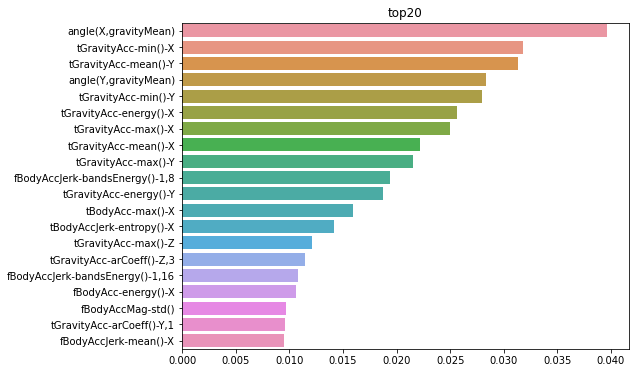

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

best_dclf = grid_cv.best_estimator_
ftr_importances_values = best_dclf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize = (8,6))
plt.title('top20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

#### GBM(Gradient Boosting Machine)
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한다.
- 분류는 물론이고 회귀도 가능
- 파라미터 : n_estimators, max_depth, max_features
 - loss : 경사하강법에서 사용할 비용함수 지정. 기본값 deviance 적용
 - learning_rate : GBM이 학습할 때마다 적용할 학습률.오류값 보정 시 적용하는 계수로 0 ~ 1 사이의 값 지정. 기본값은 0.1. 작게 설정하면 예측성능이 높아지나 수행시간이 오래 걸리고 큰 값을 적용하면 예측 성능이 떨어질 가능성이 높으나 빠른 수행이 가능. n_estimator와 상호 보완적으로 조합해 사용
 - n_estimator : weak learner의 개수
 - subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print(gb_accuracy)
print(time.time()-start_time)

0.9389209365456397
538.787134885788


In [6]:
# [과제] 상기 케이스에 대하여 성능개선을 위한 튜닝을 수행하세요.
from sklearn.model_selection import GridSearchCV

start_time = time.time()

params = {'n_estimators':[100,500],'learning_rate':[0.05,0.1]}

grid_cv = GridSearchCV(gb_clf,param_grid=params,cv=2,n_jobs=-1,verbose=True)
grid_cv.fit(X_train,y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print(gb_accuracy)

time_used = time.time()-start_time

print(time_used//60)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  5.0min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 22.9min finished


{'learning_rate': 0.1, 'n_estimators': 500}
0.9011153427638738
0.9419748897183576
68.0
